In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False, parser='auto')

In [2]:
X, y = mnist.data, mnist.target

In [3]:
X, y

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 array(['5', '0', '4', ..., '4', '5', '6'], dtype=object))

In [4]:
X.shape, y.shape

((70000, 784), (70000,))

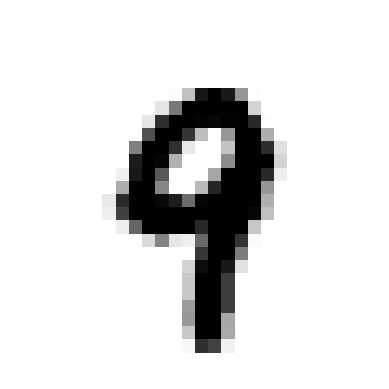

'9'

In [56]:
import random
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap='binary')
    plt.axis('off')

i = random.randint(0, len(y) - 1)
some_digit = X[i]
plot_digit(some_digit)
plt.show()
y[i]

In [6]:
train_end = 60000
X_train, X_test, y_train, y_test = X[:train_end], X[train_end:], y[:train_end], y[train_end:]

In [7]:
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

In [8]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [9]:
sgd_clf.predict([some_digit])

array([False])

In [10]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [11]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
any(dummy_clf.predict(X_train))

False

In [12]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.90965, 0.90965, 0.90965])

In [13]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3)

for train_ids, test_ids in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_fold_i = X_train[train_ids]
    y_train_5_fold_i = y_train_5[train_ids]
    X_test_fold_i = X_train[test_ids]
    y_test_5_fold_i = y_train_5[test_ids]
    
    clone_clf.fit(X_train_fold_i, y_train_5_fold_i)
    
    n_test = len(y_test_5_fold_i)
    predicts_test_5_fold_i = clone_clf.predict(X_test_fold_i)
    n_matches = sum(predicts_test_5_fold_i == y_test_5_fold_i)
    print(n_matches / n_test)

0.95035
0.96035
0.9604


In [14]:
from sklearn.model_selection import cross_val_predict

pred_train_5 = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [15]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_5, pred_train_5)
cm

array([[53892,   687],
       [ 1891,  3530]])

In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score

[f(y_train_5, pred_train_5) for f in [precision_score, recall_score, f1_score]]

[0.8370879772350012, 0.6511713705958311, 0.7325171197343846]

In [17]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([-553.58547948])

In [18]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [19]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

thresholds

array([-146348.56726174, -142300.00705404, -137588.97581744, ...,
         38871.26391927,   42216.05562787,   49441.43765905])

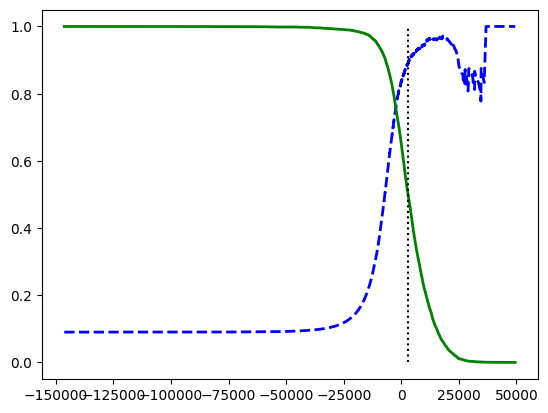

3058.896849563806

In [20]:
plt.plot(thresholds, precisions[:-1], 'b--', label='Precision', linewidth=2)
plt.plot(thresholds, recalls[:-1], 'g-', label='Recall', linewidth=2)

threshold = thresholds[57000]
plt.vlines(threshold, 0, 1.0, 'k', 'dotted', label='threshold')
plt.show()

threshold

In [21]:
idx_for_90precision = (precisions >= 0.9).argmax()
threshold_for_90precision = thresholds[idx_for_90precision]
threshold_for_90precision

3370.0194991439566

In [22]:
yhat_train_5_90p = (y_scores >= threshold_for_90precision)
precision_score(y_train_5, yhat_train_5_90p)

0.9000345901072293

In [23]:
recall_at_90p = recall_score(y_train_5, yhat_train_5_90p)
recall_at_90p

0.4799852425751706

In [24]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

thresholds

array([             inf,   49441.43765905,   36801.60697028, ...,
       -105763.22240074, -106527.45300471, -146348.56726174])

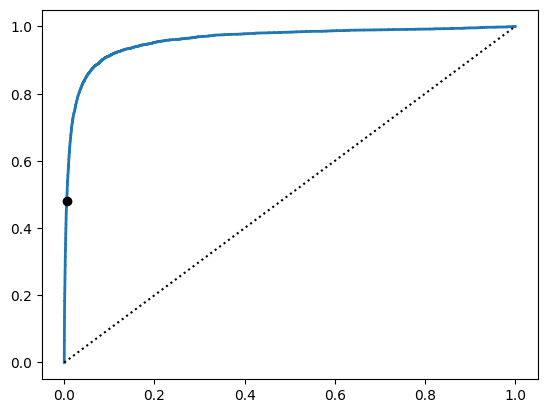

In [25]:
idx_for_90precision = (thresholds <= threshold_for_90precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_90precision], fpr[idx_for_90precision]

plt.plot(fpr, tpr, linewidth=2, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k:', label='Random classifier')
plt.plot([fpr_90], [tpr_90], 'ko', label='Threshold for 90% precision')
plt.show()

In [26]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [27]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

prob_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

In [28]:
scores_forest = prob_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, scores_forest)

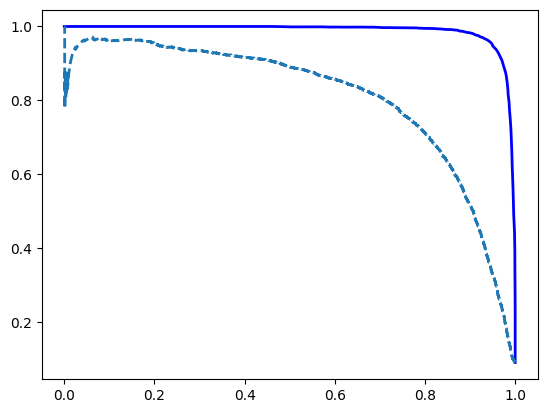

In [29]:
plt.plot(recalls_forest, precisions_forest, 'b-', linewidth=2, label='Random Forest')
plt.plot(recalls, precisions, '--', linewidth=2, label='SGD')
plt.show()

In [38]:
pred_forest = prob_forest[:, 1] > 0.5
[f(y_train_5, pred_forest) for f in [precision_score, recall_score, f1_score, roc_auc_score]]

[0.9905083315756169,
 0.8662608374838591,
 0.9242275142688446,
 0.9327181722735077]

In [39]:
from sklearn.svm import SVC

svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000])

SVC(random_state=42)

In [47]:
svm_clf.predict([some_digit])

array(['5'], dtype=object)

In [49]:
svm_clf.decision_function([some_digit]).round(2)

array([[ 7.12, -0.27,  2.74,  8.24,  0.73,  9.3 ,  4.87,  1.76,  3.8 ,
         6.24]])

In [50]:
svm_clf.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [51]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])

OneVsRestClassifier(estimator=SVC(random_state=42))

In [53]:
ovr_clf.predict([some_digit])

array(['5'], dtype='<U1')

In [54]:
len(ovr_clf.estimators_)

10

In [58]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)

SGDClassifier(random_state=42)

In [59]:
sgd_clf.predict([some_digit])

array(['9'], dtype='<U1')

In [60]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

In [61]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype('float64'))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

In [62]:
from sklearn.metrics import ConfusionMatrixDisplay

yhat_train = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

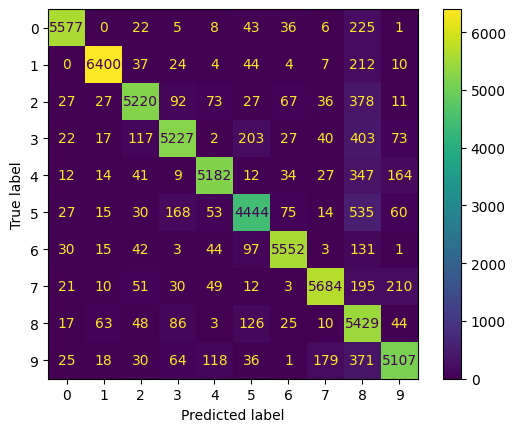

In [63]:
ConfusionMatrixDisplay.from_predictions(y_train, yhat_train)
plt.show()

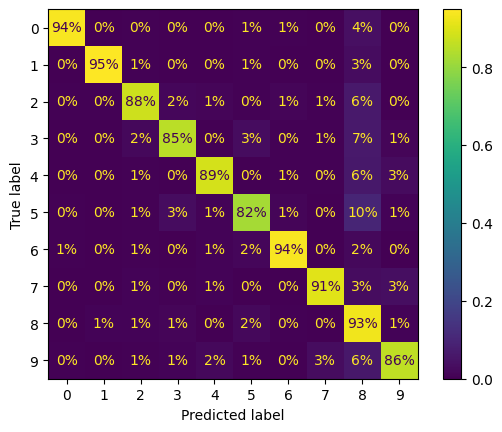

In [65]:
ConfusionMatrixDisplay.from_predictions(y_train, yhat_train, normalize='true', values_format='.0%')
plt.show()

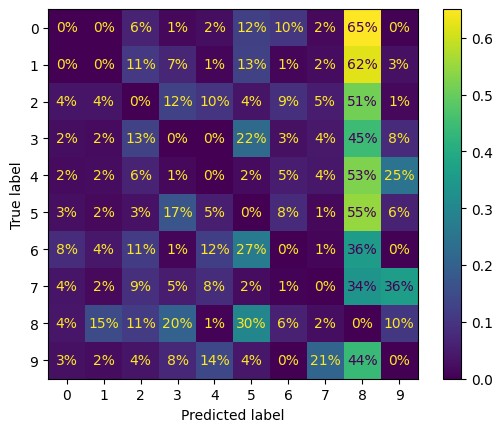

In [67]:
ConfusionMatrixDisplay.from_predictions(y_train, yhat_train, normalize='true', values_format='.0%', sample_weight=(y_train != yhat_train))

In [71]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= '7')
y_train_odd = (y_train.astype('int8') % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
y_multilabel

array([[False,  True],
       [False, False],
       [False, False],
       ...,
       [False,  True],
       [False, False],
       [ True, False]])

In [72]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [74]:
knn_clf.predict([some_digit])

array([[ True,  True]])

In [75]:
yhat_train_knn = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)

In [77]:
f1_score(y_multilabel, yhat_train_knn, average='macro')

0.976410265560605

In [78]:
from sklearn.multioutput import ClassifierChain

chain_clf = ClassifierChain(SVC(), cv=3, random_state=42)
chain_clf.fit(X_train[:2000], y_multilabel[:2000])

ClassifierChain(base_estimator=SVC(), cv=3, random_state=42)

In [79]:
chain_clf.predict([some_digit])

array([[1., 1.]])

In [81]:
np.random.seed(42)
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

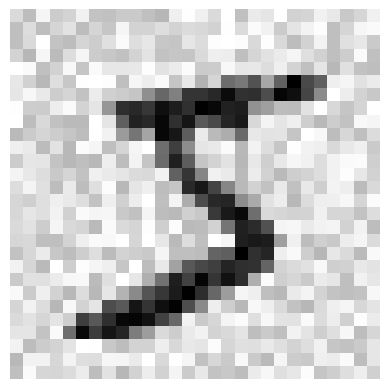

In [83]:
plot_digit(X_train_mod[0])

In [85]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)

KNeighborsClassifier()

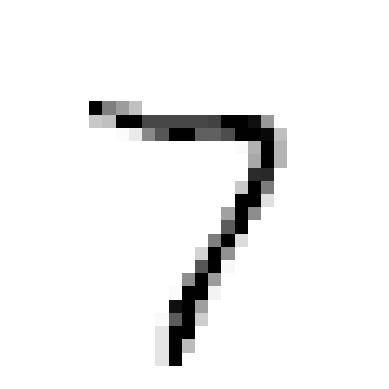

In [86]:
clean_digit = knn_clf.predict([X_test_mod[0]])
plot_digit(clean_digit)
plt.show()